In [1]:
# %%
import numpy as np
import matplotlib
#matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import scipy as sp
import math
import time


In [2]:
# set Constants

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter


#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

print('material 1 wave speeds:' ,cl1,ct1)

#Choose ferquency to be used for excitment
frequency = 120000

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency


#MATERIAL 2  (air)
pRatio2= 0.99
yModulus2= 1.13*(10**5)
rho2 = 1.15       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = 2 * mu2 * pRatio2 / (1 - 2 * pRatio2)     

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency


#dimensions of materials in meters
#the dimensions of material 1 should be greater than material 2
#diensions of material 1 

length1 = 1.0
width1 = 0.1524
height1 = 0.1524




material 1 wave speeds: 5796.653896162343 3152.519949406393
material 2 wave speeds: nan 157.1262571780358


/local/scr/dchendrickson01/TMPDIR/ipykernel_79627/2831828723.py:34: RuntimeWarning: invalid value encountered in sqrt
  cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)


In [3]:
#Run for 6 Cycles:
runtime = 8 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1) / 36)    #grid step
ts = gs/((max(cl1,ct1))*(np.sqrt(3)))*0.8732 #time step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs))   +1     #length 
gw1 = int(math.ceil(width1 / gs))      +1   #width
gh1 = int(math.ceil(height1 / gs))       +1 #height


#print(runtime, ts, gs, Tsteps, gl, gh)

print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
print('grid step size, # of length pts, # of height pts, # of width pts:', gs, gl1, gw1,gh1)




runtime (s), time step size (s), total # of time steps: 6.666666666666667e-05 6.346727117289275e-08 1052
grid step size, # of length pts, # of height pts, # of width pts: 0.0007297499882885169 1372 210 210


In [4]:
#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

matProps=np.zeros((3,gl1,gw1,gh1))
matProps[0,:,:,:]=rho1
matProps[1,:,:,:]=lmbda1
matProps[2,:,:,:]=mu1


#Top 4 layers as work hardened
matProps[0,:,:,gh1-4:gh1-1]=rho1*1.25
matProps[1,:,:,gh1-4:gh1-1]=lmbda1*1.5



In [5]:
AirCut = True
if AirCut:
    #zone 1 of air, left of web
    for yy in range(int(13/36*gw1)-1):
        y = yy + 0
        for zz in range(int(16/36*gw1)):
            z = zz + int(8/36*gw1)-1
            matProps[0,:,y,z]=rho2
            matProps[1,:,y,z]=lmbda2
            matProps[2,:,y,z]=mu2

    # zone 2 of air left of head
    for yy in range(int(4/36*gw1)-1):
        y = yy + 0
        for zz in range(int(12/36*gw1)-1):
            z = zz + int(24/36*gw1)-1
            matProps[0,:,y,z]=rho2
            matProps[1,:,y,z]=lmbda2
            matProps[2,:,y,z]=mu2

    # zone 3 of air, right of web
    for yy in range(int(13/36*gw1)):
        y = yy + int(13/36*gw1)+1
        for zz in range(int(16/36*gw1)):
            z = zz + int(8/36*gw1)+1
            matProps[0,:,y,z]=rho2
            matProps[1,:,y,z]=lmbda2
            matProps[2,:,y,z]=mu2

    # zone 4 of air, right of head
    for yy in range(int(4/36*gw1)-1):
        y = yy + int(23/36*gw1)+1
        for zz in range(int(12/36*gw1)):
            z = zz + int(24/36*gw1)
            matProps[0,:,y,z]=rho2
            matProps[1,:,y,z]=lmbda2
            matProps[2,:,y,z]=mu2


In [6]:
DoThis = False
if DoThis:
    import plotly.graph_objects as go

    X, Y, Z = np.mgrid[0:gl1, 0:gw1, 0:gh1]
    values = matProps[0,:,:,:]

    fig = go.Figure(data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(),
        z=Z.flatten(),
        value=values.flatten(),
        isomin=np.min(matProps[0,:,:,:]),
        isomax=np.max(matProps[0,:,:,:]),
        opacity=0.1, # needs to be small to see through all surfaces
        surface_count=21, # needs to be a large number for good volume rendering
        ))
    fig.show()

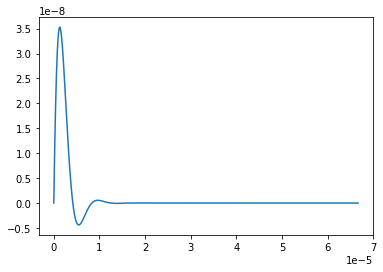

In [7]:
#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 500000
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

plt.plot(timeVec,sinInputSignal)
plt.savefig('Signal.png')
plt.show()
plt.ioff()


In [8]:
#boundary values 
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

#initialize fields
vx=np.zeros((gl1,gw1,gh1))
vy=np.zeros((gl1,gw1,gh1))
vz=np.zeros((gl1,gw1,gh1))

sxx=np.zeros((gl1,gw1,gh1))
syy=np.zeros((gl1,gw1,gh1))
szz=np.zeros((gl1,gw1,gh1))
sxy=np.zeros((gl1,gw1,gh1))
sxz=np.zeros((gl1,gw1,gh1))
syz=np.zeros((gl1,gw1,gh1))

#initialize Boundary Conditions
BCs=np.zeros((gl1,gw1,gh1),dtype='int')

#record the signal at a specified location
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vx1Signal=np.zeros(Tsteps)
vy1Signal=np.zeros(Tsteps)
vz1Signal=np.zeros(Tsteps)

vx2Signal=np.zeros(Tsteps)
vy2Signal=np.zeros(Tsteps)
vz2Signal=np.zeros(Tsteps)

TopSig00 = np.zeros(Tsteps)
TopSig10 = np.zeros(Tsteps)
TopSig20 = np.zeros(Tsteps)
TopSig30 = np.zeros(Tsteps)
TopSig40 = np.zeros(Tsteps)
TopSig50 = np.zeros(Tsteps)
TopSig60 = np.zeros(Tsteps)
TopSig70 = np.zeros(Tsteps)
TopSig80 = np.zeros(Tsteps)
TopSig90 = np.zeros(Tsteps)
TopSig99 = np.zeros(Tsteps)

In [9]:
def updateStresses(x,y,z):
    
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])

    shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
    shearxy=4*(1/gs)*(1/shearDenomxy)

    shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
    shearxz=4*(1/gs)*(1/shearDenomxz)

    shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
    shearyz=4*(1/gs)*(1/shearDenomyz)

    ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
    sxx[x,y,z]=sxx[x,y,z]+ds*ts

    ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
    syy[x,y,z]=syy[x,y,z]+ds*ts

    ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
    szz[x,y,z]=szz[x,y,z]+ds*ts

    ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
    sxy[x,y,z]=sxy[x,y,z]+ds*ts

    ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
    sxz[x,y,z]=sxz[x,y,z]+ds*ts   

    ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
    syz[x,y,z]=syz[x,y,z]+ds*ts

    #delete variables for updates
    del norm1, norm2


In [10]:
def updateStressBoundary(x,y,z):
        
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps[1,x,y,z]+2*matProps[2,x,y,z])
    norm2=(1/gs)*(matProps[1,x,y,z])


    try:
        shearDenomxy=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x+1,y+1,z])
        shearxy=4*(1/gs)*(1/shearDenomxy)
    except:
        pass
    
    try:
        shearDenomxz=(1/matProps[2,x,y,z])+(1/matProps[2,x+1,y,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x+1,y,z+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)
    except:
        pass
    
    try:
        shearDenomyz=(1/matProps[2,x,y,z])+(1/matProps[2,x,y+1,z])+(1/matProps[2,x,y,z+1])+(1/matProps[2,x,y+1,z+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)
    except:
        pass
    
    #FACES
    if BCs[x,y,z] == 1 or BCs[x,y,z] == 35:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z+1]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        sxy[x,y,z]=sxy[x,y,z]+ds*ts
        del shearxy

        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 5:


        sxx[x,y,x]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        syz[x,y,z]=syz[x,y,z]+ds*ts
        del shearyz

    elif BCs[x,y,z] == 6:
        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0

        ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
        syz[x,y,z]=syz[x,y,z]+ds*ts
        del shearyz

    elif BCs[x,y,z] == 3:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        sxz[x,y,z]=sxz[x,y,z]+ds*ts
        del shearxz

        syz[x,y,z]=0

    elif BCs[x,y,z] == 4:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0

        ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
        sxz[x,y,z]=sxz[x,y,z]+ds*ts
        del shearxz

        syz[x,y,z]=0

    elif BCs[x,y,z] == 2:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
        sxy[x,y,z]=sxy[x,y,z]+ds*ts
        del shearxy

        sxz[x,y,z]=0
        syz[x,y,z]=0


    #EDGES
    #bottom edges
    elif BCs[x,y,z] == 7 or BCs[x,y,z] == 27:

        sxx[x,y,z]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 8 or BCs[x,y,z] == 28:

        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,z] == 9 or BCs[x,y,z] == 29:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,z] == 10 or BCs[x,y,z] == 30:

        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    #side edges
    elif BCs[x,y,z] == 15:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,z] == 17:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 16:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,z] == 18:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
        szz[x,y,z]=szz[x,y,z]+ds*ts

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    #top edges
    elif BCs[x,y,z] == 11:

        sxx[x,y,z]=-sxx[x+1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 12:

        sxx[x,y,z]=-sxx[x-1,y,z]

        ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
        syy[x,y,z]=syy[x,y,z]+ds*ts

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 13:
        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    elif BCs[x,y,z] == 14:
        ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
        sxx[x,y,z]=sxx[x,y,z]+ds*ts

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0


    #CORNERS

    elif BCs[x,y,z] == 19 or BCs[x,y,z] == 31:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] ==  20:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] ==  21 or BCs[x,y,z] == 32:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 22:

        sxx[x,y,z]=-sxx[x+1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 23 or BCs[x,y,z] == 33:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 24:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y+1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] == 25 or BCs[x,y,z] == 34:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z+1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    elif BCs[x,y,z] ==  26:

        sxx[x,y,z]=-sxx[x-1,y,z]

        syy[x,y,z]=-syy[x,y-1,z]

        szz[x,y,z]=-szz[x,y,z-1]

        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0
        
    elif BCs[x,y,z] == 0:
        updateStresses(x,y,z)
        
    elif BCs[x,y,z] == 99:
        sxx[x,y,z]=0
        syy[x,y,z]=0
        szz[x,y,z]=0
        sxy[x,y,z]=0
        sxz[x,y,z]=0
        syz[x,y,z]=0

    else: print('error:', str(x), str(y), str(z))


In [11]:
def updateVelocity(x,y,z):
    #calculate constants for velocity
    
    dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
    dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
    dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
    
    dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
    vx[x,y,z]=vx[x,y,z]+dv*ts

    dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
    vy[x,y,z]=vy[x,y,z]+dv*ts

    dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
    vz[x,y,z]=vz[x,y,z]+dv*ts

    del dvxConst, dvyConst, dvzConst


In [12]:
# %%
def updateVelocityBoundary(x,y,z):
    if x!=xmax:
        dvxConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x+1,y,z]))
        vminx=(2*ts)/(matProps[0,x+1,y,z]*gs)

    if y!=ymax:
        dvyConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y+1,z]))
        vminy=(2*ts)/(matProps[0,x,y+1,z]*gs)

    if z!=zmax:
        dvzConst=2*(1/gs)*(1/(matProps[0,x,y,z]+matProps[0,x,y,z+1]))
        vminz=(2*ts)/(matProps[0,x,y,z+1]*gs)
    
    vmax=(2*ts)/(matProps[0,x,y,z]*gs)

    #FACES
    if BCs[x,y,z] == 1:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
        
        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 5:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif BCs[x,y,z] == 6:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif BCs[x,y,z] == 3:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif BCs[x,y,z] == 4:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts                     


    elif BCs[x,y,z] == 2:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    #EDGES
    #bottom edges
    elif BCs[x,y,z] == 7:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 8:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 9:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 10:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    #side edges
    elif BCs[x,y,z] == 15:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts

    elif BCs[x,y,z] == 17:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    elif BCs[x,y,z] == 16:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts



    elif BCs[x,y,z] == 18:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
        vz[x,y,z]=vz[x,y,z]+dv*ts


    #top edges
    elif BCs[x,y,z] == 11:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif BCs[x,y,z] == 12:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,z] == 13:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    elif BCs[x,y,z] == 14:

        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts

        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]

        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]


    #CORNERS
    elif BCs[x,y,z] == 19:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 20:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,z] == 21:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 22:

        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,z] == 23:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 24:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]

    elif BCs[x,y,z] == 25:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]+vminz*szz[x,y,z+1]

    elif BCs[x,y,z] == 26:

        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=vz[x,y,z]-vmax*szz[x,y,z]
        
    #veleocity blocking Boundaries
    #face
    elif BCs[x,y,z] == 35:
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
        
        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts

        vz[x,y,z]=0
    #edges
    elif BCs[x,y,z] == 27: #7
        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts
        vz[x,y,z]=0

    elif BCs[x,y,z] == 28: #8
        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

        dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
        vy[x,y,z]=vy[x,y,z]+dv*ts
        vz[x,y,z]=0
        
    elif BCs[x,y,z] == 29: #9
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=0

    elif BCs[x,y,z] == 30: #10
        dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
        vx[x,y,z]=vx[x,y,z]+dv*ts
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=0
        
    #corners
    elif BCs[x,y,z] == 31: #19
        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=0
    elif BCs[x,y,z] == 32: #21
        vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
        vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
        vz[x,y,z]=0
    elif BCs[x,y,z] == 33: #23
        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=0
    elif BCs[x,y,z] == 34: #25
        vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
        vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
        vz[x,y,z]=0
        
        
    #incase non boundaries or unknown areas snuck through
    elif BCs[x,y,z] == 99:
        vx[x,y,z]=0
        vy[x,y,z]=0
        vz[x,y,z]=0
        
    elif BCs[x,y,z] == 0:
        updateVelocity(x,y,z)
        

    else: print('error: ',x,y,z, BCs[x,y,z])


In [13]:
#Set Boundary Conditions for edges off the rail
#
def setBCsForRail(Ties = 2):
    # zone 1 of air left of web
    for yy in range(int(13/36*gw1)):
        y = yy + 0
        for zz in range(int(16/36*gh1)):
            z = zz + int(8/36*gh1)
            BCs[:,y,z]=99

    # zone 2 of air left of head
    for yy in range(int(4/36*gw1)):
        y = yy + 0
        for zz in range(int(12/36*gh1)):
            z = zz + int(24/36*gh1)
            BCs[:,y,z]=99

    # zone 3 of air, right of web
    for yy in range(int(12/36*gw1)):
        y = yy + int(24/36*gw1)-1
        for zz in range(int(16/36*gh1)):
            z = zz + int(8/36*gh1) -1
            BCs[:,y,z]=99

    # zone 4 of air, right of head
    for yy in range(int(4/36*gw1)):
        y = yy + int(32/36*gw1)
        for zz in range(int(12/36*gh1)):
            z = zz + int(24/36*gh1)
            BCs[:,y,z]=99

    #top of footing
    z = int(7/36*gh1)
    for yy in range(int(13/36*gw1)):
        y = yy + 0
        BCs[:,y,z]=2
    for yy in range(int(13/36*gw1)):
        y = yy + int(23/36*gw1)
        BCs[:,y,z]=2
    #sides of web
    y=int(13/36*gw1)
    for zz in range(int(16/36*gh1)):
        z = zz + int(8/36*gh1)
        BCs[:,y,z]=3
    y=int(23/36*gw1)
    for zz in range(int(16/36*gh1)):
        z = zz + int(8/36*gh1)
        BCs[:,y,z]=4
    #bottom of head
    z=int(12/36*gh1)
    for yy in range(int(9/36*gw1)):
        y=yy+int(5/36*gw1)
        BCs[:,y,z]=1
    for yy in range(int(9/36*gw1)):
        y=yy+int(23/36*gw1)
        BCs[:,y,z]=1
    #sides of head
    y=int(5/36*gw1)
    for zz in range(int(12/36*gh1)):
        z = zz + int(23/36*gh1)
        BCs[:,y,z]=3
    y=int(31/36*gw1)
    for zz in range(int(12/36*gh1)):
        z = zz + int(23/36*gh1)
        BCs[:,y,z]=4
    #top edge of foot on left
    BCs[:,0,int(8/36*gh1)]=13
    #top endge of foot on right
    BCs[:,ymax,int(8/36*gh1)]=14
    #bottom of head on left
    BCs[:,int(5/36*gw1),int(12/36*gh1)]=9
    #bottom of head on right
    BCs[:,int(30/36*gw1),int(12/36*gh1)]=10
    #Top of head on left
    BCs[:,int(5/36*gw1),zmax]=13
    #top of head on right
    BCs[:,int(30/36*gw1),zmax]=14
    
    if Ties ==2:  #tie on both end, absorbing all vertical velocity in square at end of track
        #face
        BCs[0:gw1,:,0]=35
        BCs[xmax-gw1:xmax,:,0]=35
        
        #Edges
        BCs[0,:,0]=27
        BCs[xmax,:,0]=28
        
        BCs[0:gw1,0,0]=29
        BCs[xmax-gw1:xmax,0,0]=29
        BCs[0:gw1,ymax,0]=30
        BCs[xmax-gw1:xmax,:,0]=30
        
        #corners
        BCs[0,0,0] = 31
        BCs[0,ymax,0]= 32
        BCs[xmax,0,0]=33
        BCs[xmax,ymax,0]=34
        
    elif Ties == 1:  #tie in the middle
        half=int(gl1/2)
        halfwidth = int(gw1/2)
        start =half - halfwidth
        end = half+halfwidth
        
        #face
        BCs[start:end,:,0]=35
        
        #edge
        BCs[start:end,0,0]=29
        BCs[start:end,ymax,0]=30
        
    elif Ties == 3: #time on both end and in middle
        #end ties
        #face
        BCs[0:gw1,:,0]=35
        BCs[xmax-gw1:xmax,:,0]=35
        
        #Edges
        BCs[0,:,0]=27
        BCs[xmax,:,0]=28
        
        BCs[0:gw1,0,0]=29
        BCs[xmax-gw1:xmax,0,0]=29
        BCs[0:gw1,ymax,0]=30
        BCs[xmax-gw1:xmax,:,0]=30
        
        #corners
        BCs[0,0,0] = 31
        BCs[0,ymax,0]= 32
        BCs[xmax,0,0]=33
        BCs[xmax,ymax,0]=34   
        
        #middle Tie
        half=int(gl1/2)
        halfwidth = int(gw1/2)
        start =half - halfwidth
        end = half+halfwidth
        
        #face
        BCs[start:end,:,0]=35
        
        #edge
        BCs[start:end,0,0]=29
        BCs[start:end,ymax,0]=30
        


In [14]:
def setBCsCube(x,y,z):
 
    #corners
    if x == 0 and y == 0 and z == 0: BCs[x,y,z] = 19
    elif x == 0 and y == 0 and z == zmax: BCs[x,y,z] = 20
    elif x == 0 and y == ymax and z == 0: BCs[x,y,z] = 21
    elif x == 0 and y == ymax and z == zmax: BCs[x,y,z] = 22
    elif x == xmax and y == 0 and z == 0: BCs[x,y,z] = 23
    elif x == xmax and y == 0 and z == zmax: BCs[x,y,z] = 24
    elif x == xmax and y == ymax and z == 0: BCs[x,y,z] = 25
    elif x == xmax and y == ymax and z == zmax: BCs[x,y,z] = 26
    
    #edges
    elif x == 0 and z == 0: BCs[x,y,z] = 7
    elif x == xmax and z == 0: BCs[x,y,z] = 8
    elif y == 0 and z == 0: BCs[x,y,z] = 9
    elif y == ymax and z == 0: BCs[x,y,z] = 10

    elif x == 0 and z == zmax: BCs[x,y,z] = 11
    elif x == xmax and z == zmax: BCs[x,y,z] = 12
    elif y == 0 and z == zmax: BCs[x,y,z] = 13
    elif y == ymax and z == zmax: BCs[x,y,z] = 14

    elif x == 0 and y == 0: BCs[x,y,z] = 15
    elif x == 0 and y == ymax: BCs[x,y,z] = 16
    elif x == xmax and y == 0: BCs[x,y,z] = 17
    elif x == xmax and y == ymax: BCs[x,y,z] = 18

    #faces
    elif z == 0: BCs[x,y,z] = 1
    elif z == zmax: BCs[x,y,z] = 2
    elif y == 0: BCs[x,y,z] = 3
    elif y == ymax: BCs[x,y,z] = 4
    elif x == 0: BCs[x,y,z] = 5
    elif x == xmax: BCs[x,y,z] = 6

def setBCs(mode = 1):
    #definig Boundary Conditions.
    # mode =1 means whole cube
    # mode =2 means rail track

    for x in range(gl1):
        for y in range(gw1):
            for z in range(gh1):
                if mode == 1: setBCsCube(x,y,z)
    if mode==2:
        setBCsForRail()
                

In [15]:
# %%
Points = []
BoundaryPoints=[]

setBCs(2)

for x in range(gl1-1):
    for y in range(gw1-1):
        for z in range(gh1-1):
            if BCs[x,y,z] == 0:
                Points.append([x,y,z])
            else:
                BoundaryPoints.append([x,y,z])




In [16]:
# %%
print(np.shape(Points)[0] + np.shape(BoundaryPoints)[0], gl1, gw1, gh1, (gl1-1)*(gw1-1)*(gh1-1))


59886651 1372 210 210 59886651


In [ ]:
# %%
stime = time.time()
jobs = 15

Tsteps = 25

#folder = '/home/dan/Code/3D_EFIT/OtherCode/images2/'
#folder ='/sciclone/scr10/dchendrickson01/3DImg/'
folder = '/sciclone/home20/dchendrickson01/Code/3D_EFIT/OtherCode/images2/'

for t in range(0,Tsteps):
    
       
    #sin-exponential input
    #vz[inputx,inputy,inputz]=vz[inputx,inputy,inputz]-szzConst*szz[inputx,inputy,inputz]+sinInputSignal[t]
    
    #update Stresses
    #Parallel(n_jobs=jobs,prefer="threads")(delayed(updateStresses)(i[0],i[1],i[2]) for i in Points)
    #for i in Points: updateStresses(i[0],i[1],i[2])
    #for i in BoundaryPoints: updateStressBoundary(i[0],i[1],i[2])
    #removed: , require='sharedmem', verbose = 0,prefer="threads")

    #if t < 50:
    dszz = np.ones((gw1,int(24/36*gw1)+1))
    dszz *= -np.sin(np.linspace(0,np.pi,int(24/36*gw1)+1))
    dszz = dszz.T
    dszz *= 795000 / np.sum(dszz) / 2 / 2.2
    #    szz[t:int(24/36*gw1)+1+t,:,zmax-1] -= dszz
    #else:
    szz[50:int(24/36*gw1)+51,:,zmax-1] = dszz
    szz[50:int(24/36*gw1)+51,:,zmax] = dszz

    #print(t,int(24/36*gw1)+1+t,int(6/36*gw1),int(30/36*gw1))
    
    #update Velocities
    #Parallel(n_jobs=jobs,prefer="threads")(delayed(updateVelocity)(i[0],i[1],i[2]) for i in Points)
    for i in Points: updateVelocity(i[0],i[1],i[2])
    for i in BoundaryPoints: updateVelocityBoundary(i[0],i[1],i[2])
    #removed: , require='sharedmem', verbose = 0,prefer="threads")
    
    #update Stresses
    for i in Points: updateStresses(i[0],i[1],i[2])
    for i in BoundaryPoints: updateStressBoundary(i[0],i[1],i[2])
        
    #record signals
    vx1Signal[t]=vx[int(signalLocx/2),signalLocy,signalLocz]
    vy1Signal[t]=vy[int(signalLocx/2),signalLocy,signalLocz]
    vz1Signal[t]=vz[int(signalLocx/2),signalLocy,signalLocz]
    
    vx2Signal[t]=vx[int(3*signalLocx/2),signalLocy,signalLocz]
    vy2Signal[t]=vy[int(3*signalLocx/2),signalLocy,signalLocz]
    vz2Signal[t]=vz[int(3*signalLocx/2),signalLocy,signalLocz]
    
    TopSig00[t] = vz[0,int(gw1/2),zmax-1]
    TopSig10[t] = vz[int(gl1*.1),int(gw1/2),zmax-1]
    TopSig20[t] = vz[int(gl1*.2),int(gw1/2),zmax-1]
    TopSig30[t] = vz[int(gl1*.3),int(gw1/2),zmax-1]
    TopSig40[t] = vz[int(gl1*.4),int(gw1/2),zmax-1]
    TopSig50[t] = vz[int(gl1*.5),int(gw1/2),zmax-1]
    TopSig60[t] = vz[int(gl1*.6),int(gw1/2),zmax-1]
    TopSig70[t] = vz[int(gl1*.7),int(gw1/2),zmax-1]
    TopSig80[t] = vz[int(gl1*.8),int(gw1/2),zmax-1]
    TopSig90[t] = vz[int(gl1*.9),int(gw1/2),zmax-1]
    TopSig99[t] = vz[xmax,int(gw1/2),zmax-1]
    
    
    #save vx cut figure
    if t%1==0:
        fig=plt.figure(figsize=(6,1.5),dpi=300)
        plt.contourf(np.transpose(vz[:,int(gw1/2),:]), cmap='seismic')
        plt.savefig(folder+'MiddleCut/MiddleCut'+str(t).zfill(5)+'.png')
        plt.close(fig)

        
        fig=plt.figure(figsize=(6,1.5),dpi=300)
        #rVel = np.sqrt(np.transpose(vx[:,:,zmax-1]) **2 + np.transpose(vy[:,:,zmax-1]) **2 + np.transpose(vz[:,:,zmax-1])**2)
        rVel = np.transpose(szz[:,:,zmax-1])
        plt.contourf(rVel, cmap='seismic')
        plt.savefig(folder+'TopSurface/TopSurfaceSTress'+str(t).zfill(5)+'.png')
        plt.close(fig)
    
    
    print(t,'/',Tsteps-1,'checksums vx, sxx:',np.sum(np.absolute(vx)),np.sum(np.absolute(sxx)), time.time()-stime)



0 / 24 checksums vx, sxx: 0.0 30239.635058735435 1858.9948825836182
1 / 24 checksums vx, sxx: 2.1214274625174103e-05 83159.0271325004 3694.806942462921
2 / 24 checksums vx, sxx: 8.126299596283537e-05 147064.53068975633 5524.563514947891


In [ ]:
# %%
plt.plot(vx1Signal)
plt.plot(vx2Signal)
plt.show()



In [ ]:
dszz = np.ones((gw1,int(24/36*gw1)+1))
dszz *= -np.sin(np.linspace(0,np.pi,int(24/36*gw1)+1))
fig=plt.figure()
plt.contourf(dszz.T, cmap='seismic')
plt.show()

In [ ]:
# %%
plt.plot(vy1Signal)
plt.plot(vy2Signal)
plt.show()



In [ ]:
TopSig00


In [ ]:
# %%
plt.plot(TopSig00,label='00%')
plt.plot(TopSig10,label='10%')
plt.plot(TopSig20,label='20%')
plt.plot(TopSig30,label='30%')
plt.plot(TopSig40,label='40%')
plt.plot(TopSig50,label='50%')
plt.plot(TopSig60,label='60%')
plt.plot(TopSig70,label='70%')
plt.plot(TopSig80,label='80%')
plt.plot(TopSig90,label='90%')
#plt.savefig('/sciclone/scr10/dchendrickson01/3DImg/VerticalsBy10.png')
plt.show()

In [ ]:
# %%
# make animated gif from saved EFIT figures

import glob

from PIL import Image


def make_gif(frame_folder, imageName = 'efit.gif'):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(f"{frame_folder}/{imageName}", format="GIF", append_images=frames,
               save_all=True, duration=50, loop=0)
    



In [ ]:
# %%
folder ='/sciclone/scr10/dchendrickson01/3DImg/'
frame_folder=folder+'/MiddleCut'
make_gif(frame_folder, 'VerticalCutMidRun0301.gif')
frame_folder=folder+'/TopSurface'
make_gif(frame_folder, 'TopSurfaceMidRun0301.gif')

In [ ]:
gs / 5.0 /ts